### Phase 3: Question Characteristics Impact

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
from scipy import stats

In [2]:
datasets = {}
model_names = ['Claude_3.5_Sonnet', 'GPT_3.5', 'GPT_4o']
file_paths = [
    '../Data/qna_dataset_Claude3.5Sonnet_final.csv',
    '../Data/qna_dataset_GPT3.5_final.csv', 
    '../Data/qna_dataset_GPT4o_final.csv'
]

In [3]:
for model_name, file_path in zip(model_names, file_paths):
    try:
        df = pd.read_csv(file_path)
        datasets[model_name] = df
        print(f"✓ {model_name}: {df.shape[0]} rows × {df.shape[1]} columns")
    except Exception as e:
        print(f"❌ Error loading {model_name}: {e}")

✓ Claude_3.5_Sonnet: 400 rows × 16 columns
✓ GPT_3.5: 400 rows × 16 columns
✓ GPT_4o: 400 rows × 16 columns


In [4]:
# Convert hallucination_present to boolean for all datasets
for model_name, df in datasets.items():
    if df['hallucination_present'].dtype == 'object':
        datasets[model_name]['hallucination_present'] = df['hallucination_present'].map({
            'True': True, 'False': False, True: True, False: False
        })

#### 1. Question length distribution by model and domain


📏 Question Length Stats by Domain (same questions across models):
  📂 General Knowledge: mean=  91.1, std=  42.9, min=34, max=204
  📂 Healthcare     : mean=  70.5, std=  46.4, min=12, max=244
  📂 History        : mean=  48.7, std=  10.1, min=35, max=82
  📂 Pop Culture    : mean= 107.6, std=  62.4, min=37, max=362
  📂 Science        : mean=  77.1, std=  32.5, min=29, max=202


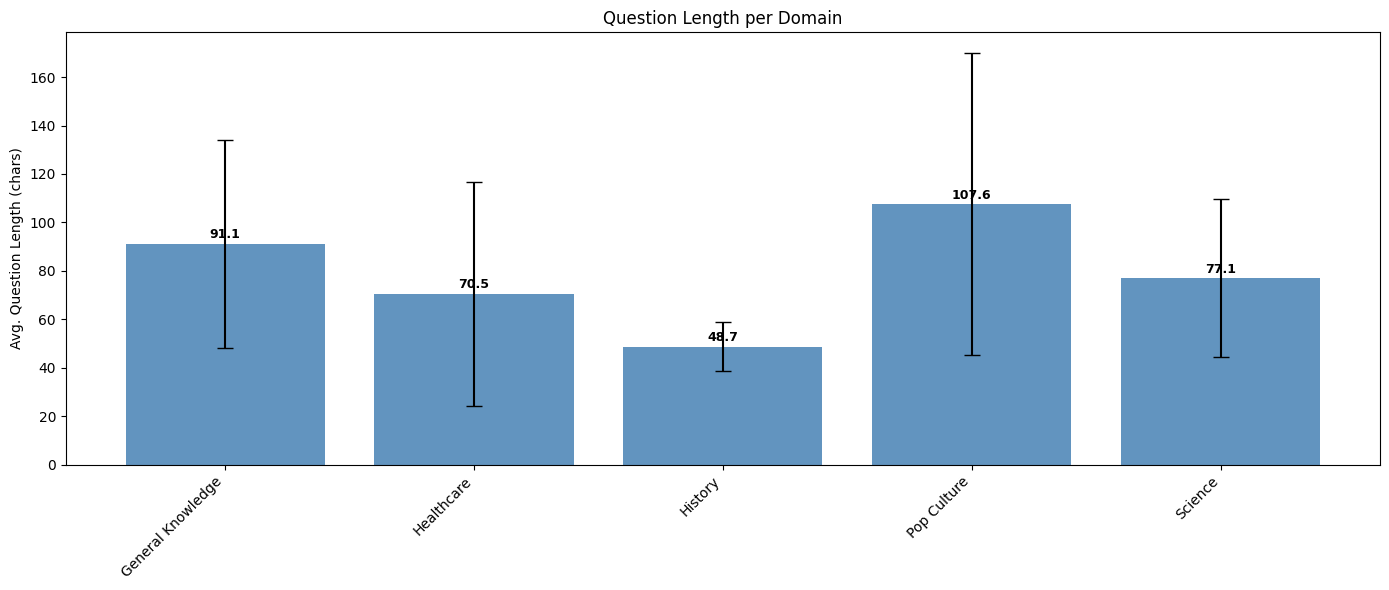

In [7]:
domain_stats = {}
all_domains = sorted(set(
    domain for df in datasets.values() for domain in df['domain'].unique()
))

print("\n📏 Question Length Stats by Domain (same questions across models):")

# Use any one model’s dataset (all have same questions/domains)
reference_df = next(iter(datasets.values()))

for domain in all_domains:
    domain_data = reference_df[reference_df['domain'] == domain]['question_length']
    mean_len = domain_data.mean()
    std_len = domain_data.std()
    min_len = domain_data.min()
    max_len = domain_data.max()
    
    domain_stats[domain] = {
        'mean': mean_len,
        'std': std_len,
        'min': min_len,
        'max': max_len
    }
    
    print(f"  📂 {domain:15}: mean={mean_len:6.1f}, std={std_len:6.1f}, min={min_len:.0f}, max={max_len:.0f}")


# Extract for plotting
means = [domain_stats[d]['mean'] for d in all_domains]
stds  = [domain_stats[d]['std'] for d in all_domains]
x = np.arange(len(all_domains))

plt.figure(figsize=(14, 6))
bars = plt.bar(x, means, yerr=stds, capsize=6, color='steelblue', alpha=0.85)

# Add value labels
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Labels and styling
plt.xticks(x, all_domains, rotation=45, ha='right')
plt.ylabel("Avg. Question Length (chars)")
plt.title("Question Length per Domain")
plt.tight_layout()
plt.show()


#### 2. Question length vs hallucination rate correlation

In [11]:
correlation_results = {}
    
for model_name, df in datasets.items():
    print(f"\n  📈 {model_name}:")
    
    # Calculate correlation
    correlation = df['question_length'].corr(df['hallucination_present'].astype(int))
    
    # Statistical significance test
    corr_coef, p_value = stats.pearsonr(df['question_length'], 
                                       df['hallucination_present'].astype(int))
    
    print(f"    Correlation coefficient: {correlation:.3f}")
    print(f"    P-value: {p_value:.4f}")
    
    if p_value < 0.001:
        significance = "*** (highly significant)"
    elif p_value < 0.01:
        significance = "** (significant)"
    elif p_value < 0.05:
        significance = "* (marginally significant)"
    else:
        significance = "(not significant)"
    
    print(f"    Statistical significance: {significance}")
    
    # Practical interpretation
    if abs(correlation) < 0.1:
        strength = "negligible"
    elif abs(correlation) < 0.3:
        strength = "weak"
    elif abs(correlation) < 0.5:
        strength = "moderate"
    else:
        strength = "strong"
    
    direction = "positive" if correlation > 0 else "negative"
    print(f"    Interpretation: {strength} {direction} relationship")
    
    correlation_results[model_name] = {
        'correlation': correlation,
        'p_value': p_value,
        'significance': significance,
        'strength': strength,
        'direction': direction
    }


  📈 Claude_3.5_Sonnet:
    Correlation coefficient: 0.073
    P-value: 0.1452
    Statistical significance: (not significant)
    Interpretation: negligible positive relationship

  📈 GPT_3.5:
    Correlation coefficient: 0.026
    P-value: 0.6016
    Statistical significance: (not significant)
    Interpretation: negligible positive relationship

  📈 GPT_4o:
    Correlation coefficient: 0.027
    P-value: 0.5875
    Statistical significance: (not significant)
    Interpretation: negligible positive relationship


#### 3. Complex vs simple question performance comparison

In [12]:
complexity_comparison = {}
    
# Define complexity thresholds (you can adjust these)
LENGTH_THRESHOLD_SIMPLE = 50   # Questions under 50 characters = simple
LENGTH_THRESHOLD_COMPLEX = 150 # Questions over 150 characters = complex

for model_name, df in datasets.items():
    print(f"\n  🎯 {model_name}:")
    
    # Categorize questions by length
    simple_questions = df[df['question_length'] <= LENGTH_THRESHOLD_SIMPLE]
    medium_questions = df[(df['question_length'] > LENGTH_THRESHOLD_SIMPLE) & 
                         (df['question_length'] <= LENGTH_THRESHOLD_COMPLEX)]
    complex_questions = df[df['question_length'] > LENGTH_THRESHOLD_COMPLEX]
    
    categories = {
        'Simple (≤50 chars)': simple_questions,
        'Medium (51-150 chars)': medium_questions,
        'Complex (>150 chars)': complex_questions
    }
    
    category_stats = {}
    
    for category_name, category_data in categories.items():
        if len(category_data) > 0:
            total = len(category_data)
            hallucinated = category_data['hallucination_present'].sum()
            rate = (hallucinated / total) * 100
            
            print(f"    {category_name:20}: {hallucinated:2d}/{total:3d} ({rate:5.1f}%)")
            
            category_stats[category_name] = {
                'total': total,
                'hallucinated': hallucinated,
                'rate': rate
            }
        else:
            print(f"    {category_name:20}: No questions in this category")
            category_stats[category_name] = {'total': 0, 'hallucinated': 0, 'rate': 0}
    
    # Statistical test for difference between simple and complex
    if len(simple_questions) > 0 and len(complex_questions) > 0:
        simple_rate = simple_questions['hallucination_present'].mean()
        complex_rate = complex_questions['hallucination_present'].mean()
        
        # Chi-square test
        from scipy.stats import chi2_contingency
        
        # Create contingency table
        simple_halluc = simple_questions['hallucination_present'].sum()
        simple_correct = len(simple_questions) - simple_halluc
        complex_halluc = complex_questions['hallucination_present'].sum()
        complex_correct = len(complex_questions) - complex_halluc
        
        contingency_table = [[simple_correct, simple_halluc],
                           [complex_correct, complex_halluc]]
        
        chi2, p_val, dof, expected = chi2_contingency(contingency_table)
        
        print(f"    Statistical test (simple vs complex):")
        print(f"      Chi-square: {chi2:.3f}, p-value: {p_val:.4f}")
        
        if p_val < 0.05:
            print(f"      ✓ Significant difference between simple and complex questions")
        else:
            print(f"      ✗ No significant difference between simple and complex questions")
    
    complexity_comparison[model_name] = category_stats


  🎯 Claude_3.5_Sonnet:
    Simple (≤50 chars)  : 14/123 ( 11.4%)
    Medium (51-150 chars): 28/247 ( 11.3%)
    Complex (>150 chars):  7/ 30 ( 23.3%)
    Statistical test (simple vs complex):
      Chi-square: 1.987, p-value: 0.1586
      ✗ No significant difference between simple and complex questions

  🎯 GPT_3.5:
    Simple (≤50 chars)  : 19/123 ( 15.4%)
    Medium (51-150 chars): 50/247 ( 20.2%)
    Complex (>150 chars):  6/ 30 ( 20.0%)
    Statistical test (simple vs complex):
      Chi-square: 0.108, p-value: 0.7419
      ✗ No significant difference between simple and complex questions

  🎯 GPT_4o:
    Simple (≤50 chars)  : 10/123 (  8.1%)
    Medium (51-150 chars): 32/247 ( 13.0%)
    Complex (>150 chars):  5/ 30 ( 16.7%)
    Statistical test (simple vs complex):
      Chi-square: 1.139, p-value: 0.2858
      ✗ No significant difference between simple and complex questions


#### 4. Domain differences in question complexity

In [13]:
domain_complexity = {}

# Use first model's data since questions are identical across models
reference_model = list(datasets.keys())[0]
df_ref = datasets[reference_model]

print(f"  📂 Domain Complexity Analysis (using {reference_model} as reference):")

for domain in df_ref['domain'].unique():
    domain_data = df_ref[df_ref['domain'] == domain]
    
    domain_stats = {
        'mean_length': domain_data['question_length'].mean(),
        'std_length': domain_data['question_length'].std(),
        'min_length': domain_data['question_length'].min(),
        'max_length': domain_data['question_length'].max(),
        'count': len(domain_data)
    }
    
    print(f"\n    {domain}:")
    print(f"      Average length: {domain_stats['mean_length']:6.1f} ± {domain_stats['std_length']:5.1f}")
    print(f"      Range: {domain_stats['min_length']:3.0f} - {domain_stats['max_length']:3.0f} characters")
    print(f"      Sample size: {domain_stats['count']} questions")
    
    domain_complexity[domain] = domain_stats

# Rank domains by average complexity
domain_ranking = sorted(domain_complexity.items(), 
                       key=lambda x: x[1]['mean_length'], reverse=True)

print(f"\n  🏆 Domain Ranking by Question Complexity:")
for i, (domain, stats) in enumerate(domain_ranking, 1):
    print(f"    {i}. {domain:15}: {stats['mean_length']:6.1f} chars average")

  📂 Domain Complexity Analysis (using Claude_3.5_Sonnet as reference):

    General Knowledge:
      Average length:   91.1 ±  42.9
      Range:  34 - 204 characters
      Sample size: 80 questions

    Science:
      Average length:   77.1 ±  32.5
      Range:  29 - 202 characters
      Sample size: 80 questions

    History:
      Average length:   48.7 ±  10.1
      Range:  35 -  82 characters
      Sample size: 80 questions

    Pop Culture:
      Average length:  107.6 ±  62.4
      Range:  37 - 362 characters
      Sample size: 80 questions

    Healthcare:
      Average length:   70.5 ±  46.4
      Range:  12 - 244 characters
      Sample size: 80 questions

  🏆 Domain Ranking by Question Complexity:
    1. Pop Culture    :  107.6 chars average
    2. General Knowledge:   91.1 chars average
    3. Science        :   77.1 chars average
    4. Healthcare     :   70.5 chars average
    5. History        :   48.7 chars average


In [18]:
domain_ranking = sorted(domain_complexity.items(), 
                           key=lambda x: x[1]['mean_length'], reverse=True)
    
print(f"\n  🏆 Domain Ranking by Question Complexity:")
for i, (domain, stats) in enumerate(domain_ranking, 1):
    print(f"    {i}. {domain:15}: {stats['mean_length']:6.1f} chars average")


# Find most complex domain
most_complex_domain = domain_ranking[0][0]
least_complex_domain = domain_ranking[-1][0]

print(f"  🔍 Most complex domain: {most_complex_domain}")
print(f"  🔍 Least complex domain: {least_complex_domain}")



  🏆 Domain Ranking by Question Complexity:
    1. Pop Culture    :  107.6 chars average
    2. General Knowledge:   91.1 chars average
    3. Science        :   77.1 chars average
    4. Healthcare     :   70.5 chars average
    5. History        :   48.7 chars average
  🔍 Most complex domain: Pop Culture
  🔍 Least complex domain: History


##### Performance by question_type (closed vs open-ended)

In [19]:
 question_type_results = {}
    
for model_name, df in datasets.items():
    print(f"\n  📊 {model_name}:")
    
    type_performance = {}
    
    for qtype in df['question_type'].unique():
        type_data = df[df['question_type'] == qtype]
        total = len(type_data)
        hallucinated = type_data['hallucination_present'].sum()
        rate = (hallucinated / total) * 100 if total > 0 else 0
        
        type_performance[qtype] = {
            'total': total,
            'hallucinated': hallucinated,
            'rate': rate
        }
        
        print(f"    {qtype:15}: {hallucinated:3d}/{total:3d} ({rate:5.1f}%)")
    
    # Statistical test if we have both types
    unique_types = list(type_performance.keys())
    if len(unique_types) >= 2 and all(type_performance[t]['total'] > 0 for t in unique_types):
        # Chi-square test for independence
        contingency_data = []
        type_labels = []
        
        for qtype in unique_types:
            correct = type_performance[qtype]['total'] - type_performance[qtype]['hallucinated']
            halluc = type_performance[qtype]['hallucinated']
            contingency_data.append([correct, halluc])
            type_labels.append(qtype)
        
        if len(contingency_data) >= 2:
            chi2, p_value, dof, expected = chi2_contingency(contingency_data)
            
            print(f"\n    Statistical Test:")
            print(f"      Chi-square: {chi2:.3f}")
            print(f"      P-value: {p_value:.4f}")
            
            if p_value < 0.05:
                print(f"      ✓ Significant difference between question types")
                
                # Identify which type performs better
                rates = [type_performance[t]['rate'] for t in unique_types]
                best_type_idx = rates.index(min(rates))  # Lower hallucination rate is better
                best_type = unique_types[best_type_idx]
                print(f"      🏆 Better performance: {best_type}")
            else:
                print(f"      ✗ No significant difference between question types")
    
    question_type_results[model_name] = type_performance


  📊 Claude_3.5_Sonnet:
    closed-ended   :  48/391 ( 12.3%)
    open-ended     :   1/  9 ( 11.1%)

    Statistical Test:
      Chi-square: 0.000
      P-value: 1.0000
      ✗ No significant difference between question types

  📊 GPT_3.5:
    closed-ended   :  75/391 ( 19.2%)
    open-ended     :   0/  9 (  0.0%)

    Statistical Test:
      Chi-square: 1.052
      P-value: 0.3050
      ✗ No significant difference between question types

  📊 GPT_4o:
    closed-ended   :  46/391 ( 11.8%)
    open-ended     :   1/  9 ( 11.1%)

    Statistical Test:
      Chi-square: 0.000
      P-value: 1.0000
      ✗ No significant difference between question types


##### Performance by Question Style (Qualitative vs Quantitative)

In [21]:
question_style_results = {}

for model_name, df in datasets.items():
    print(f"\n  📊 {model_name}:")
    
    style_performance = {}
    
    for style in df['question_style'].unique():
        style_data = df[df['question_style'] == style]
        total = len(style_data)
        hallucinated = style_data['hallucination_present'].sum()
        rate = (hallucinated / total) * 100 if total > 0 else 0
        
        style_performance[style] = {
            'total': total,
            'hallucinated': hallucinated,
            'rate': rate
        }
        
        # Add emoji indicators
        if style == 'qualitative':
            emoji = "📝"
        elif style == 'quantitative':
            emoji = "📊"
        else:
            emoji = "❓"
        
        print(f"    {emoji} {style:15}: {hallucinated:3d}/{total:3d} ({rate:5.1f}%)")
    
    # Statistical test for style differences
    unique_styles = list(style_performance.keys())
    if len(unique_styles) >= 2 and all(style_performance[s]['total'] > 0 for s in unique_styles):
        contingency_data = []
        
        for style in unique_styles:
            correct = style_performance[style]['total'] - style_performance[style]['hallucinated']
            halluc = style_performance[style]['hallucinated']
            contingency_data.append([correct, halluc])
        
        if len(contingency_data) >= 2:
            chi2, p_value, dof, expected = chi2_contingency(contingency_data)
            
            print(f"\n    Statistical Test:")
            print(f"      Chi-square: {chi2:.3f}")
            print(f"      P-value: {p_value:.4f}")
            
            if p_value < 0.05:
                print(f"      ✓ Significant difference between question styles")
                
                rates = [style_performance[s]['rate'] for s in unique_styles]
                best_style_idx = rates.index(min(rates))
                best_style = unique_styles[best_style_idx]
                print(f"      🏆 Better performance: {best_style}")
            else:
                print(f"      ✗ No significant difference between question styles")
    
    question_style_results[model_name] = style_performance


  📊 Claude_3.5_Sonnet:
    📝 qualitative    :  44/373 ( 11.8%)
    📊 quantitative   :   5/ 27 ( 18.5%)

    Statistical Test:
      Chi-square: 0.525
      P-value: 0.4685
      ✗ No significant difference between question styles

  📊 GPT_3.5:
    📝 qualitative    :  68/373 ( 18.2%)
    📊 quantitative   :   7/ 27 ( 25.9%)

    Statistical Test:
      Chi-square: 0.539
      P-value: 0.4630
      ✗ No significant difference between question styles

  📊 GPT_4o:
    📝 qualitative    :  39/373 ( 10.5%)
    📊 quantitative   :   8/ 27 ( 29.6%)

    Statistical Test:
      Chi-square: 7.173
      P-value: 0.0074
      ✓ Significant difference between question styles
      🏆 Better performance: qualitative


##### Performance by question_nature (general vs topical)

In [22]:
 question_nature_results = {}
    
for model_name, df in datasets.items():
    print(f"\n  📊 {model_name}:")
    
    nature_performance = {}
    
    for nature in df['question_nature'].unique():
        nature_data = df[df['question_nature'] == nature]
        total = len(nature_data)
        hallucinated = nature_data['hallucination_present'].sum()
        rate = (hallucinated / total) * 100 if total > 0 else 0
        
        nature_performance[nature] = {
            'total': total,
            'hallucinated': hallucinated,
            'rate': rate
        }
        
        # Add emoji indicators
        if nature == 'general':
            emoji = "🌐"
        elif nature == 'topical':
            emoji = "🎯"
        else:
            emoji = "❓"
        
        print(f"    {emoji} {nature:15}: {hallucinated:3d}/{total:3d} ({rate:5.1f}%)")
    
    question_nature_results[model_name] = nature_performance



  📊 Claude_3.5_Sonnet:
    🌐 general        :  27/337 (  8.0%)
    🎯 topical        :  22/ 63 ( 34.9%)

  📊 GPT_3.5:
    🌐 general        :  51/337 ( 15.1%)
    🎯 topical        :  24/ 63 ( 38.1%)

  📊 GPT_4o:
    🌐 general        :  31/337 (  9.2%)
    🎯 topical        :  16/ 63 ( 25.4%)


##### Model consistency across question characteristics

In [23]:
consistency_analysis = {}
    
# Analyze which models are most consistent across different question types
for characteristic in ['question_type', 'question_style', 'question_nature']:
    print(f"\n  📊 Consistency by {characteristic.replace('_', ' ').title()}:")
    
    characteristic_consistency = {}
    
    for model_name, df in datasets.items():
        rates_by_char = []
        
        for char_value in df[characteristic].unique():
            char_data = df[df[characteristic] == char_value]
            if len(char_data) > 5:  # Only include if sufficient sample size
                rate = (char_data['hallucination_present'].sum() / len(char_data)) * 100
                rates_by_char.append(rate)
        
        if len(rates_by_char) >= 2:
            # Calculate coefficient of variation as consistency measure
            consistency_score = np.std(rates_by_char) / np.mean(rates_by_char) if np.mean(rates_by_char) > 0 else 0
            characteristic_consistency[model_name] = {
                'rates': rates_by_char,
                'consistency_score': consistency_score,
                'mean_rate': np.mean(rates_by_char),
                'std_rate': np.std(rates_by_char)
            }
            
            print(f"    {model_name:15}: CV={consistency_score:.3f} "
                  f"(mean={np.mean(rates_by_char):5.1f}%, std={np.std(rates_by_char):5.1f}%)")
    
    # Rank models by consistency (lower CV = more consistent)
    if characteristic_consistency:
        sorted_models = sorted(characteristic_consistency.items(), 
                             key=lambda x: x[1]['consistency_score'])
        
        print(f"    🏆 Most consistent: {sorted_models[0][0]} (CV={sorted_models[0][1]['consistency_score']:.3f})")
        
    consistency_analysis[characteristic] = characteristic_consistency


  📊 Consistency by Question Type:
    Claude_3.5_Sonnet: CV=0.050 (mean= 11.7%, std=  0.6%)
    GPT_3.5        : CV=1.000 (mean=  9.6%, std=  9.6%)
    GPT_4o         : CV=0.029 (mean= 11.4%, std=  0.3%)
    🏆 Most consistent: GPT_4o (CV=0.029)

  📊 Consistency by Question Style:
    Claude_3.5_Sonnet: CV=0.222 (mean= 15.2%, std=  3.4%)
    GPT_3.5        : CV=0.174 (mean= 22.1%, std=  3.8%)
    GPT_4o         : CV=0.478 (mean= 20.0%, std=  9.6%)
    🏆 Most consistent: GPT_3.5 (CV=0.174)

  📊 Consistency by Question Nature:
    Claude_3.5_Sonnet: CV=0.627 (mean= 21.5%, std= 13.5%)
    GPT_3.5        : CV=0.431 (mean= 26.6%, std= 11.5%)
    GPT_4o         : CV=0.468 (mean= 17.3%, std=  8.1%)
    🏆 Most consistent: GPT_3.5 (CV=0.431)


## **📊 Model Profiles:**

### **GPT-4o: "The Specialist"**
- ✅ **Excellent for mixed question types** (CV=0.029)
- ❌ **Struggles with quantitative questions** (CV=0.478)
- **Best for**: General knowledge applications where question format varies
- **Avoid for**: Math, statistics, numerical analysis

### **GPT-3.5: "The Inconsistent Performer"** 
- ❌ **Terrible consistency across question types** (CV=1.000)
- ✅ **Good with different question styles** (CV=0.174)
- **Best for**: Applications where you can control question formatting
- **Avoid for**: Mixed question type environments

### **Claude: "The Balanced but Unpredictable"**
- ✅ **Generally consistent across most categories**
- ❌ **Major weakness with general vs topical knowledge** (CV=0.627)
- **Best for**: Specialized domain applications
- **Avoid for**: General knowledge chatbots

